In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from skimage.color import label2rgb
from tifffile import imread

from yoeo.main import get_dv2_model, get_upsampler_and_expr, get_hr_feats, get_lr_feats
from yoeo.utils import convert_image, to_numpy, closest_crop, do_2D_pca
from interactive_seg_backend import featurise_, FeatureConfig


SEED = 10672
np.random.seed(SEED)
torch.manual_seed(SEED)

N CPUS: 110


In [2]:
torch.cuda.empty_cache()

DEVICE = "cuda:0"

In [3]:
def rescale(arr: np.ndarray, swap_channels: bool=True) -> np.ndarray:
    if swap_channels:
        arr = np.transpose(arr, (1, 2, 0))
    h, w, c = arr.shape
    flat = arr.reshape((h * w, c))
    rescaled_flat = MinMaxScaler(clip=True).fit_transform(flat)
    return rescaled_flat.reshape((h, w, c))

In [4]:

cmap = [
            "#fafafa",
            "#1f77b4",
            "#ff7f0e",
            "#2ca02c",
            "#d62728",
        ]
color_list = [[255, 255, 255], [31, 119, 180], [255, 127, 14], [44, 160, 44], [255, 0, 0]]
COLORS = np.array(color_list) / 255.0

img = Image.open('fig_data/intro_column/needle_block.jpg')
labels = imread('fig_data/intro_column/glutamic_more.tiff')

labels_unsqueezed = np.expand_dims(labels, -1)

overlay = label2rgb(labels, colors=COLORS[1:], kind='overlay', bg_label=0, image_alpha=1, alpha=1)
out = np.where(labels_unsqueezed, overlay * 255, np.array(img)).astype(np.uint8)
img_with_labels = Image.fromarray(out)

In [5]:
classical_cfg = FeatureConfig()
classical_feats = featurise_(np.array(img), classical_cfg)

In [6]:
classical_reduced = do_2D_pca(classical_feats.transpose(-1, 0, 1), 3, post_norm='minmax')

In [7]:
dv2 = get_dv2_model(True, device=DEVICE)

model_path = "../trained_models/e5000_full_fit_reg.pth"
cfg_path = "../yoeo/models/configs/combined_no_shift.json"

upsampler, expr = get_upsampler_and_expr(model_path, cfg_path, device=DEVICE)

Using cache found in /home/ronan/.cache/torch/hub/ywyue_FiT3D_main


In [8]:
tr = closest_crop(img.height, img.width)
lr_feats, _ = get_lr_feats(dv2, [convert_image(img, tr)], fit3d=True)
lr_feats = F.interpolate(lr_feats, (img.height, img.width))

In [9]:
lr_feats_np = to_numpy(lr_feats)
lr_feats_np = rescale(lr_feats_np)

In [10]:
hr_feats = get_hr_feats(img, dv2, upsampler, DEVICE, n_ch_in=expr.n_ch_in)
hr_feats_np = to_numpy(hr_feats)
hr_feats_np = rescale(hr_feats_np)
print(hr_feats_np.shape)

(629, 750, 128)


In [11]:
classical_seg = imread('fig_data/intro_column/glutamic_no_crf_classical.tiff')
classical_seg_img = label2rgb(classical_seg, colors=COLORS[1:])
deep_seg = imread('fig_data/intro_column/glutamic_no_crf_deep.tiff')
deep_seg_img = label2rgb(deep_seg, colors=COLORS[1:])

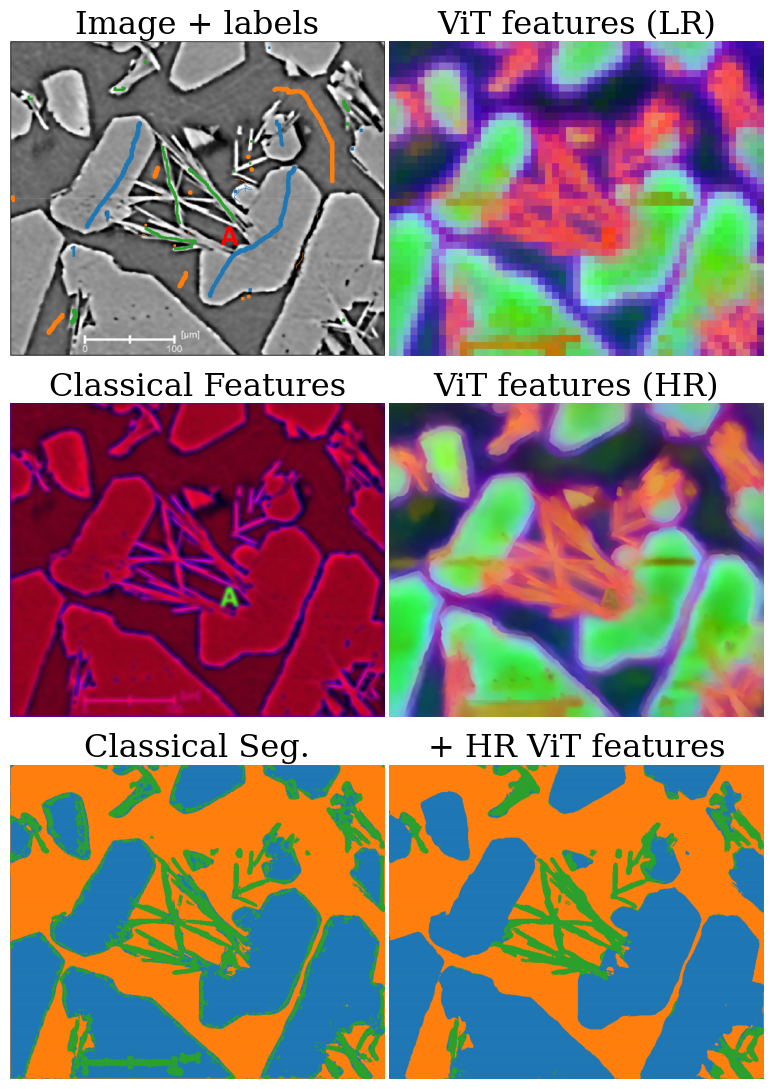

In [28]:
# %%capture
LABEL_FS = 23
LABEL_PAD = 0
ROT = 90
plt.rcParams["font.family"] = "serif"

fig, axs = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches((8.6, 11))


titles = ('Image + labels', 'ViT features (LR)', 'Classical Features', 'ViT features (HR)', 'Classical Seg.', '+ HR ViT features')
for i, a in enumerate(axs.flatten()):
    a.set_xticklabels([])
    a.set_yticklabels([])
    # a.tick_params(which="both", bottom=False, top=False, left=False, right=False)
    # a.set_aspect('equal')
    a.set_axis_off()

    a.set_title(titles[i], fontsize=LABEL_FS)

    # if i == 0:
    #     a.set_ylabel('Image', fontsize=20)
    # elif i == 1:
    #     # a.yaxis.set_label_position("right")
    #     a.set_ylabel('ViT features (LR)', fontsize=LABEL_FS, rotation=ROT, labelpad=LABEL_PAD)
    # elif i == 2:
    #     a.set_ylabel('Classical Features', fontsize=LABEL_FS)
    # elif i == 3:
    #     # a.yaxis.set_label_position("right")
    #     a.set_ylabel('ViT features (HR)', fontsize=LABEL_FS, rotation=ROT, labelpad=LABEL_PAD)
    # elif i == 4:
    #     a.set_ylabel('Classical Seg.', fontsize=LABEL_FS)
    # elif i == 5:
    #     # a.yaxis.set_label_position("right")
    #     a.set_ylabel('+ HR ViT features', fontsize=LABEL_FS, rotation=ROT, labelpad=LABEL_PAD)
    

axs[0, 0].imshow(img_with_labels)
axs[0, 1].imshow(lr_feats_np[:, :, :3].astype(np.float64))
axs[1, 0].imshow(classical_reduced)
axs[1, 1].imshow(hr_feats_np[:, :, :3].astype(np.float64))
axs[2, 0].imshow(classical_seg_img)
axs[2, 1].imshow(deep_seg_img)

plt.tight_layout()
plt.subplots_adjust(wspace=-0.16)
plt.margins(x=0)
plt.savefig('fig_out/intro_column.png' ,bbox_inches='tight')